Name: Biruk Kiros Meles


Single Run zero shot

The conll2003_data's English data was taken from the Reuters Corpus. This corpus consists of Reuters news stories between August 1996 and August 1997.

LLM: Gemini 1.5 flash Free tier

In [ ]:
# Initial setup - import all required libraries
import datasets
from datasets import load_dataset
import spacy
import numpy as np
import openai  # or your chosen LLM client
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
import json
import os
import urllib.request
import zipfile

# Create a directory to store the data
data_dir = "/content/conll2003_data"  # Colab paths start with /content/
os.makedirs(data_dir, exist_ok=True)

# Download the dataset
dataset_url = "https://data.deepai.org/conll2003.zip"
zip_path = os.path.join(data_dir, "conll2003.zip")
urllib.request.urlretrieve(dataset_url, zip_path)

# Extract the files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print(f"Dataset downloaded to: {data_dir}")

check the dataset

In [3]:
# Check what files we have
!ls -l "/content/conll2003_data"

# Expected files:
# - test.txt
# - train.txt
# - valid.txt


total 5716
-rw-r--r-- 1 root root  982975 Jun 14 21:35 conll2003.zip
-rw-r--r-- 1 root root     153 Jun 14 21:35 metadata
-rw-r--r-- 1 root root  748095 Jun 14 21:35 test.txt
-rw-r--r-- 1 root root 3283420 Jun 14 21:35 train.txt
-rw-r--r-- 1 root root  827443 Jun 14 21:35 valid.txt


see the sentecnes


In [4]:
def view_sentences(file_path, num_samples=5):
    """View sample sentences from a file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        current_sentence = []
        samples_shown = 0

        print(f"\nFirst {num_samples} sentences from {file_path}:")
        for line in f:
            line = line.strip()
            if not line:
                if current_sentence:
                    print(f"{samples_shown+1}. {' '.join(current_sentence)}")
                    current_sentence = []
                    samples_shown += 1
                    if samples_shown >= num_samples:
                        break
                continue
            token = line.split()[0]  # First item is the token
            current_sentence.append(token)

# View training set sentences
view_sentences("/content/conll2003_data/train.txt")

# View validation set sentences
view_sentences("/content/conll2003_data/valid.txt", 3)

# View test set sentences
view_sentences("/content/conll2003_data/test.txt", 3)


First 5 sentences from /content/conll2003_data/train.txt:
1. -DOCSTART-
2. EU rejects German call to boycott British lamb .
3. Peter Blackburn
4. BRUSSELS 1996-08-22
5. The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .

First 3 sentences from /content/conll2003_data/valid.txt:
1. -DOCSTART-
2. CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
3. LONDON 1996-08-30

First 3 sentences from /content/conll2003_data/test.txt:
1. -DOCSTART-
2. SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
3. Nadim Ladki


#Display the senteces and their tags


In [5]:
def view_tagged_sentences(file_path, num_samples=2):
    """View sentences with their NER and POS tags, skipping the first line of the file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip the first line

        current_sentence = []
        current_pos_tags = []
        current_ner_tags = []
        samples_shown = 0

        print(f"\nTagged samples from {file_path}:")
        for line in f:
            line = line.strip()
            if not line:
                if current_sentence:
                    print(f"\nSentence {samples_shown+1}:")
                    print("Text:", ' '.join(current_sentence))
                    print("Tokens:", current_sentence)
                    print("POS Tags:", current_pos_tags)
                    print("NER Tags:", current_ner_tags)

                    current_sentence = []
                    current_pos_tags = []
                    current_ner_tags = []
                    samples_shown += 1
                    if samples_shown >= num_samples:
                        break
                continue
            parts = line.split()
            if len(parts) >= 4:
                current_sentence.append(parts[0])       # Token
                current_pos_tags.append(parts[1])       # POS tag
                current_ner_tags.append(parts[-1])      # NER tag (last element)
view_tagged_sentences("/content/conll2003_data/train.txt", 5)



Tagged samples from /content/conll2003_data/train.txt:

Sentence 1:
Text: EU rejects German call to boycott British lamb .
Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
POS Tags: ['NNP', 'VBZ', 'JJ', 'NN', 'TO', 'VB', 'JJ', 'NN', '.']
NER Tags: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

Sentence 2:
Text: Peter Blackburn
Tokens: ['Peter', 'Blackburn']
POS Tags: ['NNP', 'NNP']
NER Tags: ['B-PER', 'I-PER']

Sentence 3:
Text: BRUSSELS 1996-08-22
Tokens: ['BRUSSELS', '1996-08-22']
POS Tags: ['NNP', 'CD']
NER Tags: ['B-LOC', 'O']

Sentence 4:
Text: The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
Tokens: ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'w

Analyze TAG distribution





Tag distribution in /content/conll2003_data/train.txt:
O: 170523
B-LOC: 7140
B-PER: 6600
B-ORG: 6321
I-PER: 4528
I-ORG: 3704
B-MISC: 3438
I-LOC: 1157
I-MISC: 1155


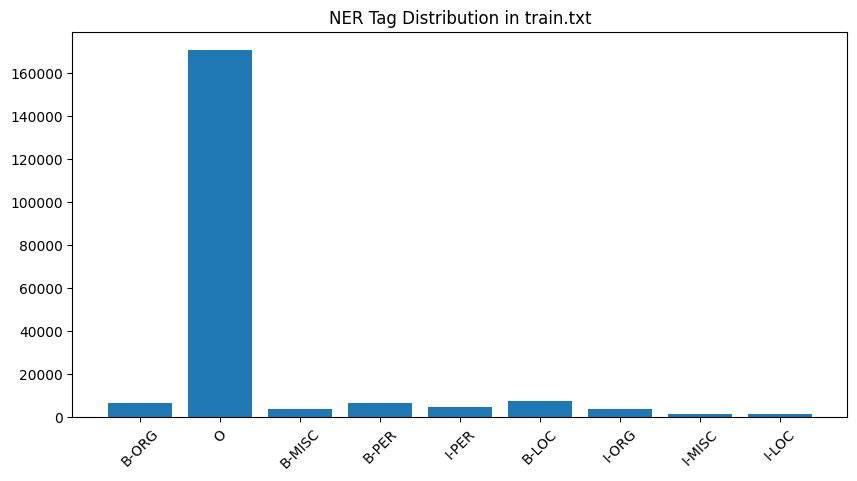

In [6]:
from collections import Counter

def analyze_tags(file_path):
    tag_counter = Counter()

    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            line = line.strip()
            if line:  # Skip empty lines
                tag = line.split()[-1]  # Last element is NER tag
                tag_counter[tag] += 1

    print(f"\nTag distribution in {file_path}:")
    for tag, count in tag_counter.most_common():
        print(f"{tag}: {count}")

    # Plot the distribution
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.bar(tag_counter.keys(), tag_counter.values())##Important! - Log distribution
    plt.title(f"NER Tag Distribution in {file_path.split('/')[-1]}")
    plt.xticks(rotation=45)
    plt.show()

# Analyze training set tags
analyze_tags("/content/conll2003_data/train.txt")

#Proper data split


Incase there will be a need for finetuning a local model too.


In [7]:
import random
from sklearn.model_selection import train_test_split

def load_for_zero_shot_ner_with_pos(data_dir="/content/conll2003_data",
                                   val_size=0.05,
                                   random_state=42):
    """
    Load dataset for zero-shot NER with POS tags.
    Only returns a small dev set for prompt testing and a test set for evaluation.

    Returns:
        dev_data: list of dicts with tokens, pos_tags, tags
        test_data: list of dicts with tokens, pos_tags, tags
    """
    def load_conll_file(file_path):
        sentences = []
        current_sentence = []
        current_pos_tags = []
        current_tags = []

        with open(file_path, 'r', encoding='utf-8') as f:
            next(f)  # skip header
            for line in f:
                line = line.strip()
                if not line:
                    if current_sentence:
                        sentences.append({
                            'tokens': current_sentence,
                            'pos_tags': current_pos_tags,
                            'tags': current_tags
                        })
                        current_sentence = []
                        current_pos_tags = []
                        current_tags = []
                    continue
                parts = line.split()
                current_sentence.append(parts[0])      # token
                current_pos_tags.append(parts[1])      # pos tag (2nd column)
                current_tags.append(parts[-1])         # ner tag (last column)
        return sentences

    # Load full training and test data
    full_train_data = load_conll_file(f"{data_dir}/train.txt")
    test_data = load_conll_file(f"{data_dir}/test.txt")

    # Split training data to get dev set for prompt tuning
    if val_size > 0:
        dev_data, _ = train_test_split(
            full_train_data,
            test_size=1 - val_size,
            random_state=random_state
        )
        print(f"Loaded {len(dev_data)} dev (prompt tuning) sentences")
    else:
        dev_data = []

    print(f"Loaded {len(test_data)} test sentences for evaluation")

    return dev_data, test_data

# Usage example
dev_data, test_data = load_for_zero_shot_ner_with_pos(val_size=0.02)


Loaded 299 dev (prompt tuning) sentences
Loaded 3683 test sentences for evaluation


In [8]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f8c85fe5be64308671d9fc0d891d55c7367ed2854076f612c35c9ad739021b80
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


#Lets see the structure of our dev_data and test_data


In [9]:
from seqeval.metrics.sequence_labeling import get_entities

def display_ner_samples_with_pos(data, num_samples=3, title="Sample Sentences"):
    print(f"\n📄 {title} ({num_samples} samples shown):\n" + "-" * 50)

    for i, sample in enumerate(data[:num_samples]):
        tokens = sample['tokens']
        pos_tags = sample.get('pos_tags', ['_'] * len(tokens))  # fallback if missing
        tags = sample['tags']
        sentence = " ".join(tokens)
        entities = get_entities(tags)  # list of (entity_type, start, end)

        print(f"\n🔹 Sentence {i+1}:")
        print("Text:", sentence)
        print("Tokens:", tokens)
        print("POS Tags:", pos_tags)
        print("NER Tags:", tags)

        if entities:
            print("Entities:")
            for ent_type, start, end in entities:
                entity_text = " ".join(tokens[start:end+1])
                print(f"  - {entity_text} [{ent_type}]")
        else:
            print("Entities: None")

# Run display
display_ner_samples_with_pos(dev_data, num_samples=3, title="Prompt Tuning (Dev) Data")
display_ner_samples_with_pos(test_data, num_samples=3, title="Evaluation (Test) Data")



📄 Prompt Tuning (Dev) Data (3 samples shown):
--------------------------------------------------

🔹 Sentence 1:
Text: The Russians , working for the Aerostan firm in the Russian republic of Tatarstan , were taken hostage after a Taleban MiG-19 fighter forced their cargo plane to land in August 1995 .
Tokens: ['The', 'Russians', ',', 'working', 'for', 'the', 'Aerostan', 'firm', 'in', 'the', 'Russian', 'republic', 'of', 'Tatarstan', ',', 'were', 'taken', 'hostage', 'after', 'a', 'Taleban', 'MiG-19', 'fighter', 'forced', 'their', 'cargo', 'plane', 'to', 'land', 'in', 'August', '1995', '.']
POS Tags: ['DT', 'NNPS', ',', 'VBG', 'IN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', 'NNP', ',', 'VBD', 'VBN', 'NN', 'IN', 'DT', 'NNP', 'NNP', 'NN', 'VBD', 'PRP$', 'NN', 'NN', 'TO', 'VB', 'IN', 'NNP', 'CD', '.']
NER Tags: ['O', 'B-MISC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

#Our NER processing class


In [10]:
import requests
import json
import time
from datetime import datetime
from collections import defaultdict
import spacy
from sklearn.model_selection import train_test_split

# ANSI color codes for error highlighting
class Colors:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Load English language model for syntactic parsing
nlp = spacy.load("en_core_web_sm")

class ConllNERProcessor:

    def __init__(self, api_key='your_api_key'):
        self.api_key = api_key
        self.endpoint = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent"
        self.headers = {'Content-Type': 'application/json'}
        self.request_count = 0
        self.last_request_time = datetime.now()
        self.entity_types = ['PER', 'ORG', 'LOC', 'MISC']
        self.rate_limit = {
            'requests_per_minute': 60,
            'requests_per_batch': 15,
            'batch_interval': 60  # seconds
        }
        # Enhanced backoff parameters
        self.backoff_factor = 60
        self.max_backoff = 320

    def _rate_limit(self):
        """Enforce rate limiting with adaptive backoff"""
        now = datetime.now()
        elapsed = (now - self.last_request_time).total_seconds()

        # Reset counter if more than batch interval has passed
        if elapsed > self.rate_limit['batch_interval']:
            self.request_count = 0
            self.last_request_time = now
            return

        # Check if we need to wait
        if self.request_count >= self.rate_limit['requests_per_batch']:
            wait_time = self.rate_limit['batch_interval'] - elapsed
            print(f"{Colors.YELLOW}Rate limit: Waiting {wait_time:.1f} seconds...{Colors.ENDC}")
            time.sleep(wait_time)
            self.request_count = 0
            self.last_request_time = datetime.now()

    def generate(self, prompt, temperature=0, max_retries=5):
        """Send prompt with enhanced rate limiting and retry logic"""
        for attempt in range(max_retries):
            try:
                self._rate_limit()

                params = {'key': self.api_key}
                payload = {
                    "contents": [{
                        "parts": [{
                            "text": prompt
                        }]
                    }],
                    "generationConfig": {
                        "responseMimeType": "application/json",
                        "temperature": temperature
                    }
                }

                response = requests.post(
                    self.endpoint,
                    params=params,
                    headers=self.headers,
                    json=payload,
                    timeout=120  # Increased timeout
                )

                response.raise_for_status()
                return response.json()

            except requests.exceptions.HTTPError as e:
                if e.response.status_code == 429:
                    backoff = min(self.max_backoff, self.backoff_factor ** (attempt + 1))
                    print(f"{Colors.RED}Rate limited (429). Waiting {backoff}s...{Colors.ENDC}")
                    time.sleep(backoff)
                    continue
                print(f"{Colors.RED}HTTP Error: {e}{Colors.ENDC}")
                return None
            except requests.exceptions.Timeout:
                print(f"{Colors.RED}Request timeout. Retrying...{Colors.ENDC}")
                time.sleep(3)
            except Exception as e:
                print(f"{Colors.RED}Attempt {attempt + 1} failed: {str(e)}{Colors.ENDC}")
                time.sleep(1)

        print(f"{Colors.RED}Failed after {max_retries} attempts{Colors.ENDC}")
        return None

    def prepare_conll_example(self, sentence_data):
        """Convert CoNLL format to text with entity markers"""
        tokens = sentence_data['tokens']
        tags = sentence_data['tags']

        # Convert BIO tags to entity spans
        entities = []
        current_entity = None
        start_idx = 0

        for i, tag in enumerate(tags):
            if tag.startswith('B-'):
                if current_entity is not None:
                    entities.append((start_idx, i-1, current_entity))
                current_entity = tag[2:]
                start_idx = i
            elif tag.startswith('I-'):
                if current_entity is None or tag[2:] != current_entity:
                    # Invalid tag sequence, treat as O
                    if current_entity is not None:
                        entities.append((start_idx, i-1, current_entity))
                    current_entity = None
            else:  # O
                if current_entity is not None:
                    entities.append((start_idx, i-1, current_entity))
                    current_entity = None

        if current_entity is not None:
            entities.append((start_idx, len(tokens)-1, current_entity))

        return tokens, entities

    def evaluate_predictions(self, gold_data, pred_entities):
        """Calculate precision, recall, and F1 with detailed error analysis"""
        true_pos = 0
        false_pos = 0
        false_neg = 0
        error_details = []

        for i, (gold, pred) in enumerate(zip(gold_data, pred_entities)):
            gold_tokens, gold_ents = gold
            gold_set = set((start, end, type) for start, end, type in gold_ents)
            pred_set = set((start, end, type) for start, end, type in pred)

            # Calculate metrics
            tp = len(gold_set & pred_set)
            fp = len(pred_set - gold_set)
            fn = len(gold_set - pred_set)

            true_pos += tp
            false_pos += fp
            false_neg += fn

            # Store error details for visualization
            if fp > 0 or fn > 0:
                error_details.append({
                    'index': i,
                    'tokens': gold_tokens,
                    'gold_entities': gold_ents,
                    'pred_entities': pred,
                    'tp': tp,
                    'fp': fp,
                    'fn': fn
                })

        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_pos': true_pos,
            'false_pos': false_pos,
            'false_neg': false_neg,
            'error_details': error_details
        }

    def visualize_errors(self, tokens, gold_ents, pred_ents):
        """Visualize errors with color highlighting"""
        # Create token-level entity markers
        gold_markers = [None] * len(tokens)
        pred_markers = [None] * len(tokens)

        # Mark gold entities
        for start, end, etype in gold_ents:
            for i in range(start, end + 1):
                if i < len(tokens):
                    gold_markers[i] = etype

        # Mark predicted entities
        for start, end, etype in pred_ents:
            for i in range(start, end + 1):
                if i < len(tokens):
                    pred_markers[i] = etype

        # Generate colored output
        output = []
        i = 0
        while i < len(tokens):
            # Check for matching entities
            if gold_markers[i] == pred_markers[i] and gold_markers[i] is not None:
                # Correct entity
                start = i
                entity_type = gold_markers[i]
                while i < len(tokens) and gold_markers[i] == entity_type:
                    i += 1
                entity_text = " ".join(tokens[start:i])
                output.append(f"{Colors.GREEN}[{entity_text}:{entity_type}]{Colors.ENDC}")
                continue

            # Handle errors
            if gold_markers[i] is not None:
                # False negative (gold entity not predicted)
                start = i
                entity_type = gold_markers[i]
                while i < len(tokens) and gold_markers[i] == entity_type:
                    i += 1
                entity_text = " ".join(tokens[start:i])
                output.append(f"{Colors.RED}[{entity_text}:{entity_type}]{Colors.ENDC}")
                continue

            if pred_markers[i] is not None:
                # False positive (predicted entity not in gold)
                start = i
                entity_type = pred_markers[i]
                while i < len(tokens) and pred_markers[i] == entity_type:
                    i += 1
                entity_text = " ".join(tokens[start:i])
                output.append(f"{Colors.BLUE}[{entity_text}:{entity_type}]{Colors.ENDC}")
                continue

            # No entity
            output.append(tokens[i])
            i += 1

        return " ".join(output)

    def _parse_response(self, response):
        """More robust response parsing"""
        try:
            content = response['candidates'][0]['content']['parts'][0]['text']

            # Clean response - sometimes Gemini adds extra text
            json_start = content.find('[')
            json_end = content.rfind(']') + 1

            if json_start == -1 or json_end == 0:
                return []

            entities = json.loads(content[json_start:json_end])

            # Validate entities format
            valid_entities = []
            for entity in entities:
                if isinstance(entity, list) and len(entity) == 2:
                    if isinstance(entity[0], str) and isinstance(entity[1], str):
                        valid_entities.append(entity)
            return valid_entities

        except Exception as e:
            print(f"{Colors.RED}Error parsing response: {e}{Colors.ENDC}")
            return []

    def _find_token_spans(self, sentence_tokens, entity_tokens):
        """Find all possible spans matching entity tokens in sentence"""
        matches = []
        sentence_len = len(sentence_tokens)
        entity_len = len(entity_tokens)

        for i in range(sentence_len - entity_len + 1):
            match = True
            for j in range(entity_len):
                if sentence_tokens[i+j].lower() != entity_tokens[j].lower():
                    match = False
                    break
            if match:
                matches.append((i, i+entity_len-1))

        return matches

    def evaluate_method(self, method_name, dataset, sample_size=None, max_errors=10):
        """Evaluate a method on a dataset with progress tracking and error visualization"""
        if sample_size:
            dataset = dataset[:sample_size]

        results = []
        start_time = time.time()

        # Prepare gold data with tokens
        gold_data = []
        for sample in dataset:
            tokens, entities = self.prepare_conll_example(sample)
            gold_data.append((tokens, entities))

        for i, sample in enumerate(dataset):
            print(f"\rProcessing {i+1}/{len(dataset)}...", end="", flush=True)

            if method_name == 'decomposed_qa':
                pred = self.decomposed_qa(sample)
            elif method_name == 'tool_augmented':
                pred = self.tool_augmented(sample)
            elif method_name == 'self_consistency':
                pred = self.self_consistency(sample)
            else:
                raise ValueError(f"Unknown method: {method_name}")

            results.append(pred)

        # Evaluate predictions
        metrics = self.evaluate_predictions(gold_data, results)

        print(f"\n\n{Colors.BOLD}{method_name} evaluation completed in {time.time()-start_time:.1f}s{Colors.ENDC}")
        print(f"{Colors.BOLD}Precision: {metrics['precision']:.3f}{Colors.ENDC}")
        print(f"{Colors.BOLD}Recall: {metrics['recall']:.3f}{Colors.ENDC}")
        print(f"{Colors.BOLD}F1: {metrics['f1']:.3f}{Colors.ENDC}")
        print(f"True Positives: {metrics['true_pos']}")
        print(f"False Positives: {metrics['false_pos']}")
        print(f"False Negatives: {metrics['false_neg']}")

        # Display error details
        error_details = metrics['error_details']
        if error_details:
            print(f"\n{Colors.UNDERLINE}Error Samples (showing first {min(max_errors, len(error_details))}):{Colors.ENDC}")
            for error in error_details[:max_errors]:
                print(f"\n{Colors.BOLD}Sentence #{error['index']+1}{Colors.ENDC}")
                print(f"True Positives: {error['tp']}, False Positives: {error['fp']}, False Negatives: {error['fn']}")

                # Visualize errors
                visualization = self.visualize_errors(
                    error['tokens'],
                    error['gold_entities'],
                    error['pred_entities']
                )
                print("Text with entities:")
                print(visualization)

                # Print entity lists
                print("\nGold Entities:")
                for start, end, etype in error['gold_entities']:
                    entity_text = " ".join(error['tokens'][start:end+1])
                    print(f"- [{entity_text}:{etype}]")

                print("\nPredicted Entities:")
                for start, end, etype in error['pred_entities']:
                    entity_text = " ".join(error['tokens'][start:end+1])
                    print(f"- [{entity_text}:{etype}]")

                print("\n" + "-"*50)
        else:
            print(f"\n{Colors.GREEN}No errors found!{Colors.ENDC}")

        return metrics




#Methods

**Decompose QA**

The paper's decomposed QA uses multi-turn dialogues processing one entity type per turn, with ChatGPT-determined label orders and accumulated context between turns. This sequential approach reduces ambiguity for nested entities but requires multiple API calls. Our implementation collapses this into a single-turn extraction where all entity types are identified simultaneously using a fixed label order and JSON output format. While faster with one API call, it lacks inter-label context and may struggle with complex entity interactions, though both methods share the core decomposition philosophy of isolating entity recognition tasks.
I saw an increase in F1 score(~0.3) with the single turn method I implemented below, compared to the one that was used in the Paper. Additionaly the cost was reduced 3 times. From 5 requests per minutes to 15 request per minute per sentence.

In [11]:
def decomposed_qa(self, sentence_data):
    tokens, _ = self.prepare_conll_example(sentence_data)
    text = " ".join(tokens)

    prompt = f"""Identify all entities in this text following CoNLL-2003 NER guidelines.
Entity types: {', '.join(self.entity_types)}

Text: "{text}"

Instructions:
- Extract ALL entity types in one pass
- Return list of entities in format: [["entity text", "TYPE"]]
- Only return the JSON list, nothing else

Entities:"""

    response = self.generate(prompt)
    if not response:
        return []

    entities = self._parse_response(response)
    results = []
    for entity_text, entity_type in entities:
        if entity_type not in self.entity_types:
            continue

        entity_tokens = entity_text.split()
        matches = self._find_token_spans(sentence_data['tokens'], entity_tokens)
        for start, end in matches:
            results.append((start, end, entity_type))

    return results
ConllNERProcessor.decomposed_qa = decomposed_qa



**Tool Augmented Comparison**

The paper combines syntactic parsing with decomposed QA, using HanLP-generated features (POS/dependency/constituency trees) and explicit reasoning prompts. It employs noun phrases and domain-specific label orders for technical datasets. Our enhanced tool augmentation maintains single-turn execution while incorporating spaCy-generated POS/dependency tags and noun phrases, with a structured prompt directing syntactic analysis before extraction. Though both leverage external parsers, our approach consolidates syntax into one prompt section rather than per-label decomposition, trading some granularity for efficiency while adopting the paper's "analyze then extract" logic.

In [12]:
def tool_augmented(self, sentence_data):
        tokens, _ = self.prepare_conll_example(sentence_data)
        text = " ".join(tokens)

        # Generate syntactic information
        doc = nlp(text)
        pos_tags = [(token.text, token.pos_) for token in doc]
        dep_tags = [(token.text, token.dep_) for token in doc]

        prompt = f"""Perform CoNLL-2003 NER with syntactic information:

Text: "{text}"
POS tags: {pos_tags}
Dependency tags: {dep_tags}
Entity types: {self.entity_types}

Instructions:
1. Analyze syntactic structure first
2. Identify entities based on text and syntax
3. Return list in format: [["entity text", "TYPE"]]
4. Only return the JSON list, nothing else

Entities:"""

        response = self.generate(prompt)
        if not response:
            return []

        entities = self._parse_response(response)
        results = []
        for entity_text, entity_type in entities:
            if entity_type not in self.entity_types:
                continue

            tokens = entity_text.split()
            if len(tokens) == 0:
                continue

            matches = self._find_token_spans(sentence_data['tokens'], tokens)
            for start, end in matches:
                results.append((start, end, entity_type))
        return results

ConllNERProcessor.tool_augmented = tool_augmented



In [13]:
# Helper method for entity processing
def _process_entities(self, response, original_tokens):
    entities = self._parse_response(response)
    results = []
    for entity_text, entity_type in entities:
        if entity_type not in self.entity_types:
            continue

        entity_tokens = entity_text.split()
        matches = self._find_token_spans(original_tokens, entity_tokens)
        for start, end in matches:
            results.append((start, end, entity_type))
    return results
ConllNERProcessor._process_entities = _process_entities

**Self-Consistency Comparison**

The paper implements two-stage voting at question-level (per entity type) or sample-level (full dialogue), using 5-7 samples with adaptive backoff and special nested entity handling. Our modified self-consistency preserves single-turn execution but adopts strict two-stage voting: mentions must exceed 50% agreement across 5 samples before type voting, with mention normalization to avoid duplicates. While lacking the paper's per-label voting, we mirror its >50% thresholds and duplicate prevention, focusing vote aggregation at the sample level rather than decomposed question-level for faster execution.

In [14]:
def self_consistency(self, sentence_data, num_samples=3):
        """Self-Consistency with two-stage voting for CoNLL data"""
        tokens, _ = self.prepare_conll_example(sentence_data)
        text = " ".join(tokens)
        prompt = f"""Perform CoNLL-2003 NER with these entity types: {self.entity_types}

Text: "{text}"

Instructions:
- Extract entities matching the types
- Return list in format: [["entity text", "TYPE"]]
- Only return the JSON list, nothing else

Entities:"""

        # Stage 1: Generate multiple responses
        responses = []
        for _ in range(num_samples):
            response = self.generate(prompt, temperature=0.7)
            if response:
                entities = self._parse_response(response)
                responses.append(entities)

        if not responses:
            return []

        # Stage 2: Two-stage majority voting
        # First stage: Vote for mentions
        mention_votes = defaultdict(int)
        mention_type_map = defaultdict(lambda: defaultdict(int))

        for response in responses:
            for entity_text, entity_type in response:
                mention_votes[entity_text] += 1
                mention_type_map[entity_text][entity_type] += 1

        # Keep mentions that appear in >50% of responses
        threshold = num_samples / 2
        selected_mentions = [m for m, cnt in mention_votes.items() if cnt > threshold]

        # Second stage: Vote for types
        results = []
        for mention in selected_mentions:
            if mention not in mention_type_map:
                continue

            # Get most voted type for this mention
            selected_type = max(mention_type_map[mention].items(), key=lambda x: x[1])[0]
            if selected_type not in self.entity_types:
                continue

            # Convert to token spans
            tokens = mention.split()
            matches = self._find_token_spans(sentence_data['tokens'], tokens)
            for start, end in matches:
                results.append((start, end, selected_type))

        return results

ConllNERProcessor.self_consistency = self_consistency


#Evaluation

Color-Coding Legend

Green - Correct Prediction (True Positive)	      [U.N.:ORG] (Correctly tagged as ORG)

Red – Gold entity not predicted	           [Paris:LOC] (Gold says LOC, but model missed it)

Blue - Incorrect Prediction (False Positive) – Model predicted a wrong tag	                       [official:PER] (Gold says O, model predicted PER)

Default - Non-entity tokens (O tags)	   meets (Correctly ignored)


Important: With gemini 1.5 flash it will take arround 15 minutes to complete for 50 sentences. For more than 50 sentences it will hit the daily rate limit for the free tier API(which was used here for developing the methods and testing).



#Testing phase


In [15]:
if __name__ == "__main__":
    from IPython.display import display, HTML
    import pandas as pd

    # Display setup for Jupyter
    def display_style(text, color='black', weight='normal'):
        display(HTML(f'<span style="color:{color}; font-weight:{weight}">{text}</span>'))

    # Load dataset
    display_style("Loading dataset...", color='blue', weight='bold')
    train_data, val_data, test_data = dev_data, dev_data, dev_data

    # Initialize processor with your API key for Gemini 1.5 flash
    ner_processor = ConllNERProcessor(api_key='your_api_key')



    #******************This was used for prompt tuning the mehtods*****************
    eval_subset = dev_data[1:5]# Start with 10 samples

    #******************This was used for evaluation******************
    #eval_subset = test_data[141:191]  # testing with 50 samples

    display_style("\n=== Evaluating Methods ===", color='green', weight='bold')
    display_style(f"Using {len(eval_subset)} samples from validation set", color='blue')

    # Results storage
    results = []

    # 1. Decomposed-QA
    display_style("\n▶ Evaluating Decomposed-QA...", color='darkblue', weight='bold')
    decomposed_metrics = ner_processor.evaluate_method('decomposed_qa', eval_subset, max_errors=3)
    results.append({
        'Method': 'Decomposed-QA',
        'Precision': decomposed_metrics['precision'],
        'Recall': decomposed_metrics['recall'],
        'F1': decomposed_metrics['f1'],
        'TP': decomposed_metrics['true_pos'],
        'FP': decomposed_metrics['false_pos'],
        'FN': decomposed_metrics['false_neg']
    })

    # 2. Tool Augmentation
    display_style("\n▶ Evaluating Tool Augmentation...", color='darkblue', weight='bold')
    tool_metrics = ner_processor.evaluate_method('tool_augmented', eval_subset, max_errors=3)
    results.append({
        'Method': 'Tool Augmented',
        'Precision': tool_metrics['precision'],
        'Recall': tool_metrics['recall'],
        'F1': tool_metrics['f1'],
        'TP': tool_metrics['true_pos'],
        'FP': tool_metrics['false_pos'],
        'FN': tool_metrics['false_neg']
    })

    # 3. Self-Consistency
    display_style("\n▶ Evaluating Self-Consistency...", color='darkblue', weight='bold')
    sc_metrics = ner_processor.evaluate_method('self_consistency', eval_subset, max_errors=3)
    results.append({
        'Method': 'Self-Consistency',
        'Precision': sc_metrics['precision'],
        'Recall': sc_metrics['recall'],
        'F1': sc_metrics['f1'],
        'TP': sc_metrics['true_pos'],
        'FP': sc_metrics['false_pos'],
        'FN': sc_metrics['false_neg']
    })

    # Create and display summary table
    df = pd.DataFrame(results)
    df.set_index('Method', inplace=True)

    display_style("\n=== Summary Results ===", color='green', weight='bold')

    # Main metrics table
    styled_df1 = (df[['Precision', 'Recall', 'F1']]
                 .style
                 .format("{:.3f}")
                 .background_gradient(cmap='Blues')
                 .set_properties(**{'text-align': 'center'}))

    # Set table styles
    styled_df1.set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])

    display(styled_df1)

    # Detailed counts table
    display_style("\n=== Detailed Counts ===", color='green', weight='bold')
    styled_df2 = (df[['TP', 'FP', 'FN']]
                 .style
                 .format("{:.0f}")
                 .background_gradient(cmap='Reds')
                 .set_properties(**{'text-align': 'center'}))

    # Set table styles
    styled_df2.set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])

    display(styled_df2)

    # Final recommendations
    display_style("\n=== Recommendations ===", color='green', weight='bold')
    best_method = df['F1'].idxmax()
    display_style(f"Best performing method: {best_method} (F1: {df.loc[best_method]['F1']:.3f})",
                 color='darkgreen', weight='bold')

    if df['FP'].sum() > df['FN'].sum():
        display_style("Model tends to make more False Positives (over-prediction)", color='darkorange')
    else:
        display_style("Model tends to make more False Negatives (under-prediction)", color='darkorange')

Processing 3/4...Rate limited (429). Waiting 60s...
Rate limited (429). Waiting 320s...
Rate limited (429). Waiting 320s...
Rate limited (429). Waiting 320s...
Processing 4/4...Rate limited (429). Waiting 60s...
Rate limited (429). Waiting 320s...


KeyboardInterrupt: 